In [134]:
from log_parser import parse_keyboard_log
from log_parser import parse_mouse_log
from keyboard_heatmap import KeyboardHeatmap

# Segment length of each data sample
train_seg_length = 100
test_seg_length = 100

routing_file = open('.routing', 'r')
Lines = routing_file.readlines()

# List of parsed logfiles
keyboard = []
mouse = []

for line in Lines:
    line = line.strip()
    if 'keyboard_actions.log' in line:
        keyboard.append(parse_keyboard_log(line))
    elif 'mouse_actions.log' in line:
        mouse.append(parse_mouse_log(line))

# Split into train and test sets
X_train = []
X_test = []
Y_train = []
Y_test = []

for k in range(len(keyboard) - 1):
    for i in range(int(keyboard[k].time.iloc[-1] / train_seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, train_seg_length)
        heatmap = heatmap.to_binary_class_label("ZIRSOL")
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_train.append(heatmap.heatmap_data().ravel().tolist())
            Y_train.append(heatmap.class_label())

for k in range(len(keyboard) - 1,len(keyboard)):
    for i in range(int(keyboard[k].time.iloc[-1] / test_seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, test_seg_length)
        heatmap = heatmap.to_binary_class_label("ZIRSOL")
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_test.append(heatmap.heatmap_data().ravel().tolist())
            Y_test.append(heatmap.class_label())

print(f"Train samples: {len(Y_train)}")
print(f"Test samples: {len(Y_test)}")

Train samples: 181
Test samples: 36


In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Create random forests classifier object
# n_jobs controls multithreading, -1 uses all available threads
# criterion determines how well a feature splits data, we use gini
# max_features determines the number of candidate features available for a best split
# n_estimators determines the number of trees in our forest
# oob_score determines whether or not our forest uses out of bag error
rfc = RandomForestClassifier(n_jobs=-1, criterion='gini', max_features= 'sqrt', n_estimators = 100, oob_score = True) 

model = rfc.fit(X_train, Y_train)

# Print best score
print( f"Train score: {rfc.score(X_train, Y_train)} " + f"Test score: {rfc.score(X_test, Y_test)}")

Train score: 1.0 Test score: 0.8333333333333334


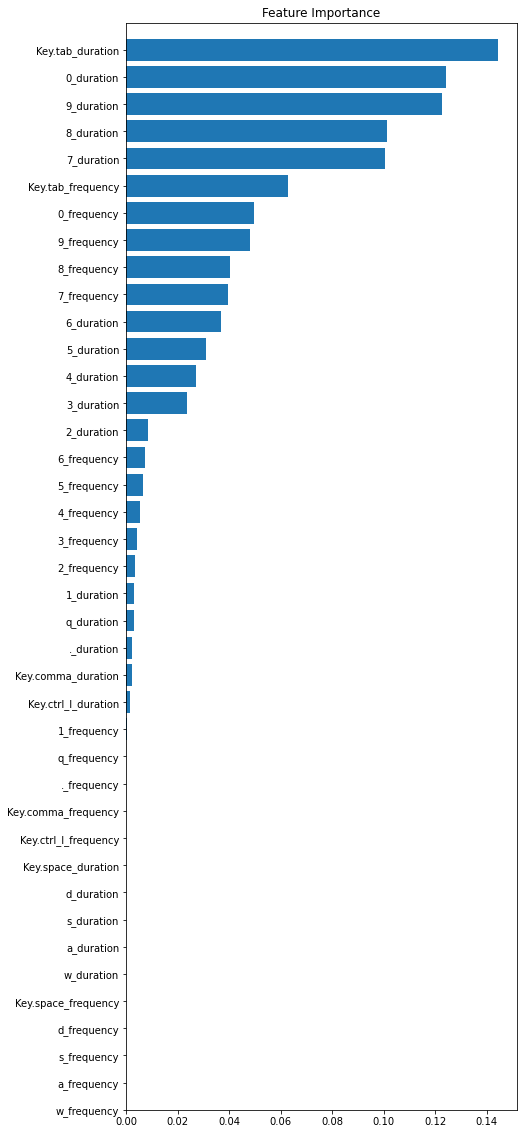

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# We want to plot the feature importance of all features to see how our classifier is splitting data
importances = model.feature_importances_
indices = np.argsort(importances)

# Expand figure vertically
plt.figure(figsize=(7,20))

# Barplot
plt.barh(range(len(indices)), importances[indices])
# Add feature names as y-axis labels
# replace [indices[i] for i in indices] with feature labels
plt.yticks(range(len(indices)), KeyboardHeatmap.heatmap_data_names())
# Set y axis limits to be a little more space efficient
plt.ylim(0, 40)
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

[Text(321.9230769230769, 570.4444444444445, 'X[39] <= 0.067\ngini = 0.305\nsamples = 110\nvalue = [147, 34]'),
 Text(274.2307692307692, 503.3333333333333, 'X[10] <= 0.005\ngini = 0.444\nsamples = 59\nvalue = [68, 34]'),
 Text(226.53846153846155, 436.22222222222223, 'X[5] <= 1.553\ngini = 0.498\nsamples = 41\nvalue = [39, 34]'),
 Text(95.38461538461539, 369.1111111111111, 'X[9] <= 0.196\ngini = 0.188\nsamples = 9\nvalue = [17, 2]'),
 Text(47.69230769230769, 302.0, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(143.0769230769231, 302.0, 'gini = 0.0\nsamples = 7\nvalue = [17, 0]'),
 Text(357.6923076923077, 369.1111111111111, 'X[8] <= 0.685\ngini = 0.483\nsamples = 32\nvalue = [22, 32]'),
 Text(238.46153846153845, 302.0, 'X[3] <= 0.235\ngini = 0.436\nsamples = 18\nvalue = [19, 9]'),
 Text(143.0769230769231, 234.88888888888886, 'X[9] <= 0.199\ngini = 0.444\nsamples = 4\nvalue = [2, 4]'),
 Text(95.38461538461539, 167.77777777777777, 'gini = 0.0\nsamples = 3\nvalue = [0, 4]'),
 Text(190.76

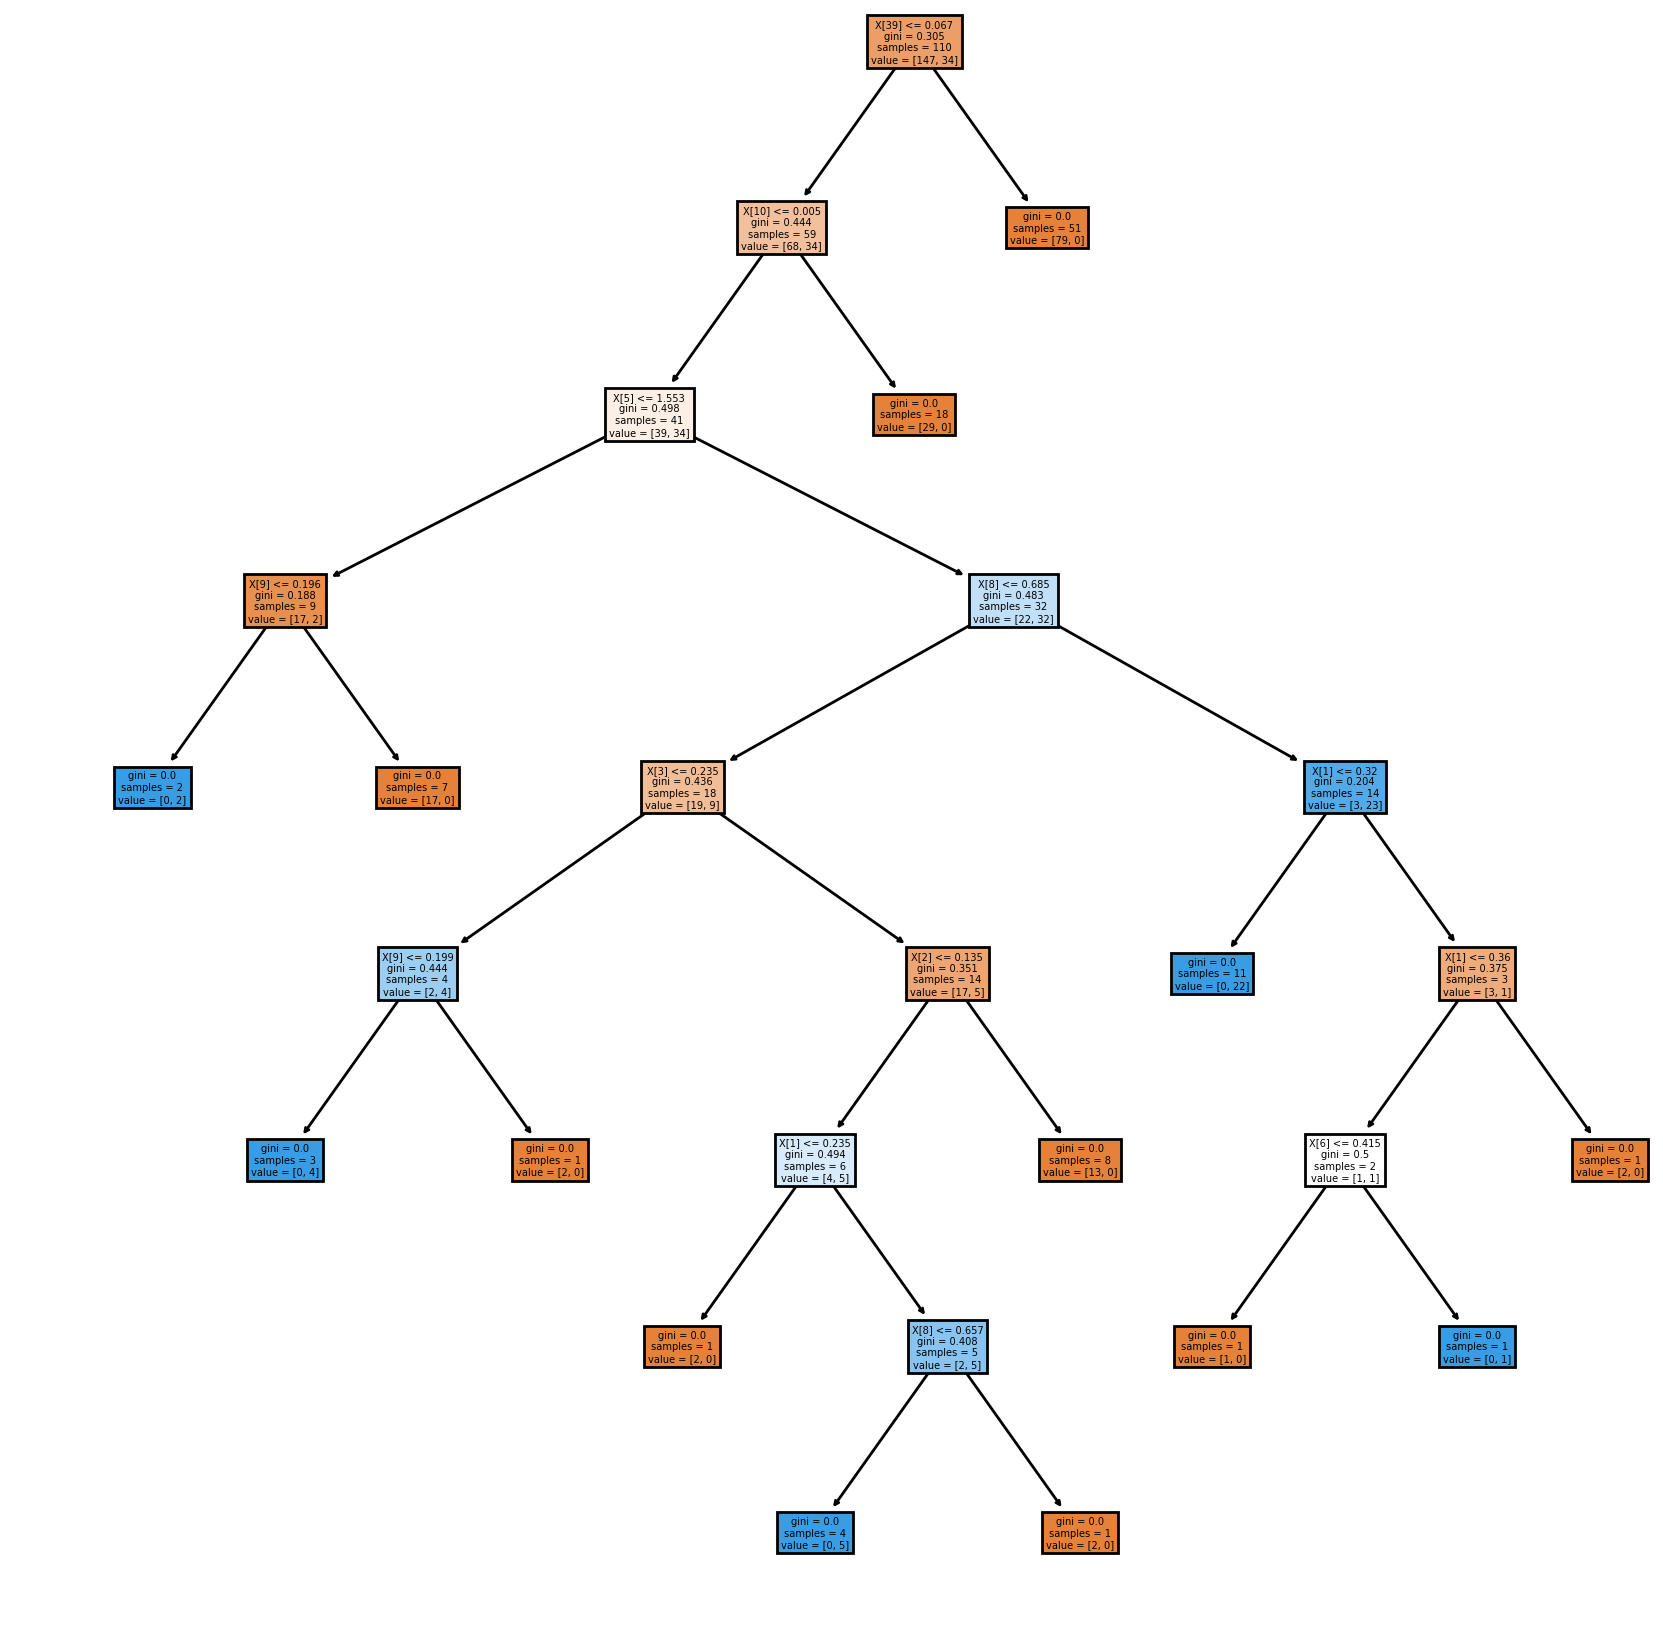

In [137]:
from sklearn import tree

# Plot one tree in our forest for fun
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(rfc.estimators_[0], feature_names = KeyboardHeatmap.heatmap_data_names(),filled = True)